In [ ]:
!pip install pycaret[analysis,models]

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

In [ ]:
#uploaded = files.upload()

In [ ]:
#filename = list(uploaded.keys())[0]
#filename

### Import data and drop useless features:

In [ ]:
df_merged= pd.read_csv('df_merged.csv')

df = df_merged.drop(['Customer ID',
                             'Count',
                             'Under 30',
                             'Dependents',
                             'Quarter',
                             'Referred a Friend',
                             'Internet Service',
                             'Customer Status',
                             'Churn Label',
                             'Churn Score',
                             'Churn Category',
                             'Churn Reason',
                             'Country',
                             'State',
                             'City',
                             'Lat Long',
                             'Latitude',
                             'Longitude',
                             'Satisfaction Score'
                            ], axis=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Age                                7043 non-null   int64  
 2   Senior Citizen                     7043 non-null   object 
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   Number of Referrals                7043 non-null   int64  
 6   Tenure in Months                   7043 non-null   int64  
 7   Offer                              3166 non-null   object 
 8   Phone Service                      7043 non-null   object 
 9   Avg Monthly Long Distance Charges  7043 non-null   float64
 10  Multiple Lines                     7043 non-null   object 
 11  Internet Type                      5517 non-null   objec

In [ ]:
df.isna().sum()

Gender                                  0
Age                                     0
Senior Citizen                          0
Married                                 0
Number of Dependents                    0
Number of Referrals                     0
Tenure in Months                        0
Offer                                3877
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Type                        1526
Avg Monthly GB Download                 0
Online Security                         0
Online Backup                           0
Device Protection Plan                  0
Premium Tech Support                    0
Streaming TV                            0
Streaming Movies                        0
Streaming Music                         0
Unlimited Data                          0
Contract                                0
Paperless Billing                       0
Payment Method                    

In [ ]:
df['Internet Type'].value_counts()

Internet Type
Fiber Optic    3035
DSL            1652
Cable           830
Name: count, dtype: int64

In [ ]:
df['Offer'].value_counts()

Offer
Offer B    824
Offer E    805
Offer D    602
Offer A    520
Offer C    415
Name: count, dtype: int64

### Perform initial preprocessing by encoding binary features and one-hot encoding categorical features:

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def encode_binary_features(df, binary_features):
    le = LabelEncoder()
    for feature in binary_features:
        df[feature] = le.fit_transform(df[feature])
    return df

def encode_multi_class_features(df, multi_class_features):
    onehotencoder = OneHotEncoder(drop='first', sparse_output=False)
    df_encoded = pd.DataFrame(onehotencoder.fit_transform(df[multi_class_features]))

    # Retrieve the column names after OneHotEncoding
    df_encoded.columns = onehotencoder.get_feature_names_out(multi_class_features)

    # Convert one-hot encoded columns to int64
    df_encoded = df_encoded.astype('int64')

    # Concatenate the original df with the one-hot encoded df
    df = pd.concat([df, df_encoded], axis=1)

    # Drop the original multi-class categorical columns
    df.drop(columns=multi_class_features, inplace=True)

    return df

def encode_ordinal_features(df, ordinal_features_mapping):
    for feature, mapping in ordinal_features_mapping.items():
        df[feature] = df[feature].map(mapping)
    return df

def convert_numeric_columns(df, numeric_columns):
    for column in numeric_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

# Define the handle_missing_values function to fill NaNs with specified values
def handle_missing_values(df):
    df['Offer'].fillna('None', inplace=True)
    df['Internet Type'].fillna('No', inplace=True)
    return df

# Define feature lists
binary_features = [
    'Phone Service', 'Multiple Lines',
    'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
    'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data'
]

multi_class_features = [
    'Gender', 'Senior Citizen', 'Married', 'Offer', 'Paperless Billing', 'Payment Method'
]

# Define ordinal feature mappings
ordinal_features_mapping = {
    'Contract': {'Month-to-Month': 0, 'One Year': 1, 'Two Year': 2},
    'Internet Type': {'No': 0, 'DSL': 1, 'Fiber Optic': 2, 'Cable': 3}
}

numeric_columns = [
    'Age', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months',
    'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
    'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges',
    'Total Long Distance Charges', 'Total Revenue', 'CLTV'
]

# Handle missing values before encoding ordinal and numeric features
df = handle_missing_values(df)

# Encode features
df = encode_binary_features(df, binary_features)
df = encode_multi_class_features(df, multi_class_features)
df = encode_ordinal_features(df, ordinal_features_mapping)

# Ensure numeric columns are indeed numeric
df = convert_numeric_columns(df, numeric_columns)


In [ ]:
df.head()

,Age,Number of Dependents,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Type,Avg Monthly GB Download,Online Security,...,Senior Citizen_Yes,Married_Yes,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,Paperless Billing_Yes,Payment Method_Credit Card,Payment Method_Mailed Check
0,78,0,0,1,0,0.00,0,1,8,0,...,1,0,0,0,0,0,0,1,0,0
1,74,1,1,8,1,48.85,1,2,17,0,...,1,1,0,0,0,0,1,1,1,0
2,71,3,0,18,1,11.33,1,2,52,0,...,1,0,0,0,0,1,0,1,0,0
3,78,1,1,25,1,19.76,0,2,12,0,...,1,1,0,0,1,0,0,1,0,0
4,80,1,1,37,1,6.33,1,2,14,0,...,1,1,0,0,1,0,0,1,0,0


In [ ]:
df.isna().sum()

Age                                  0
Number of Dependents                 0
Number of Referrals                  0
Tenure in Months                     0
Phone Service                        0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support                 0
Streaming TV                         0
Streaming Movies                     0
Streaming Music                      0
Unlimited Data                       0
Contract                             0
Monthly Charge                       0
Total Charges                        0
Total Refunds                        0
Total Extra Data Charges             0
Total Long Distance Charges          0
Total Revenue                        0
Churn Value                          0
CLTV                     

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                7043 non-null   int64  
 1   Number of Dependents               7043 non-null   int64  
 2   Number of Referrals                7043 non-null   int64  
 3   Tenure in Months                   7043 non-null   int64  
 4   Phone Service                      7043 non-null   int64  
 5   Avg Monthly Long Distance Charges  7043 non-null   float64
 6   Multiple Lines                     7043 non-null   int64  
 7   Internet Type                      7043 non-null   int64  
 8   Avg Monthly GB Download            7043 non-null   int64  
 9   Online Security                    7043 non-null   int64  
 10  Online Backup                      7043 non-null   int64  
 11  Device Protection Plan             7043 non-null   int64

### Inspect data by plotting (histograms and correlation matrix):

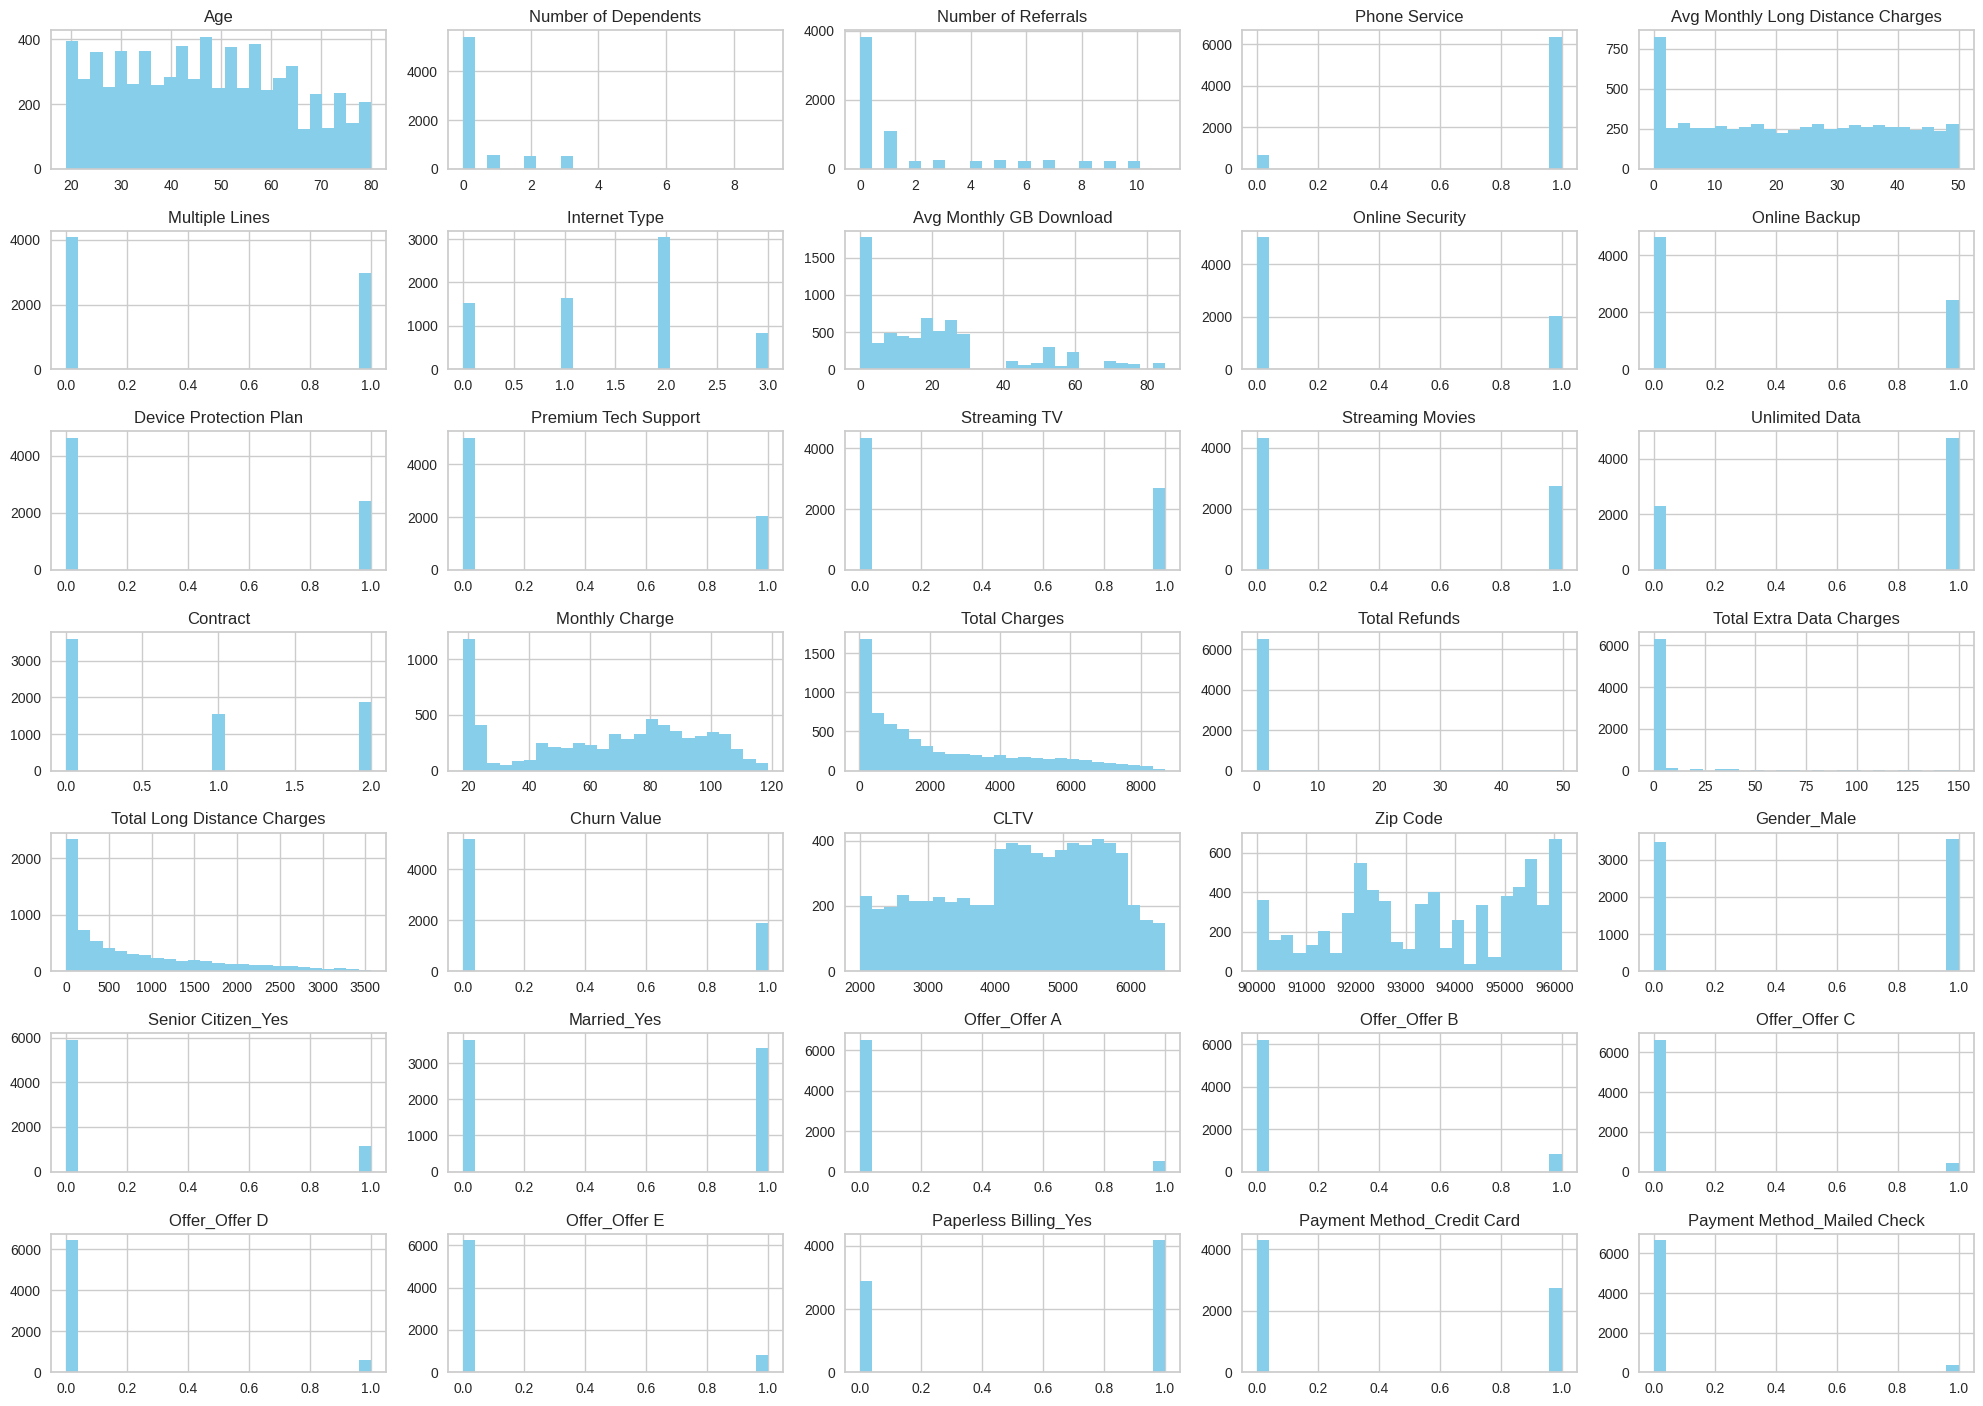

In [ ]:
df.hist(figsize=(20, 20), bins = 25, layout=(10, 5), color='skyblue')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/feature_distributions.png')

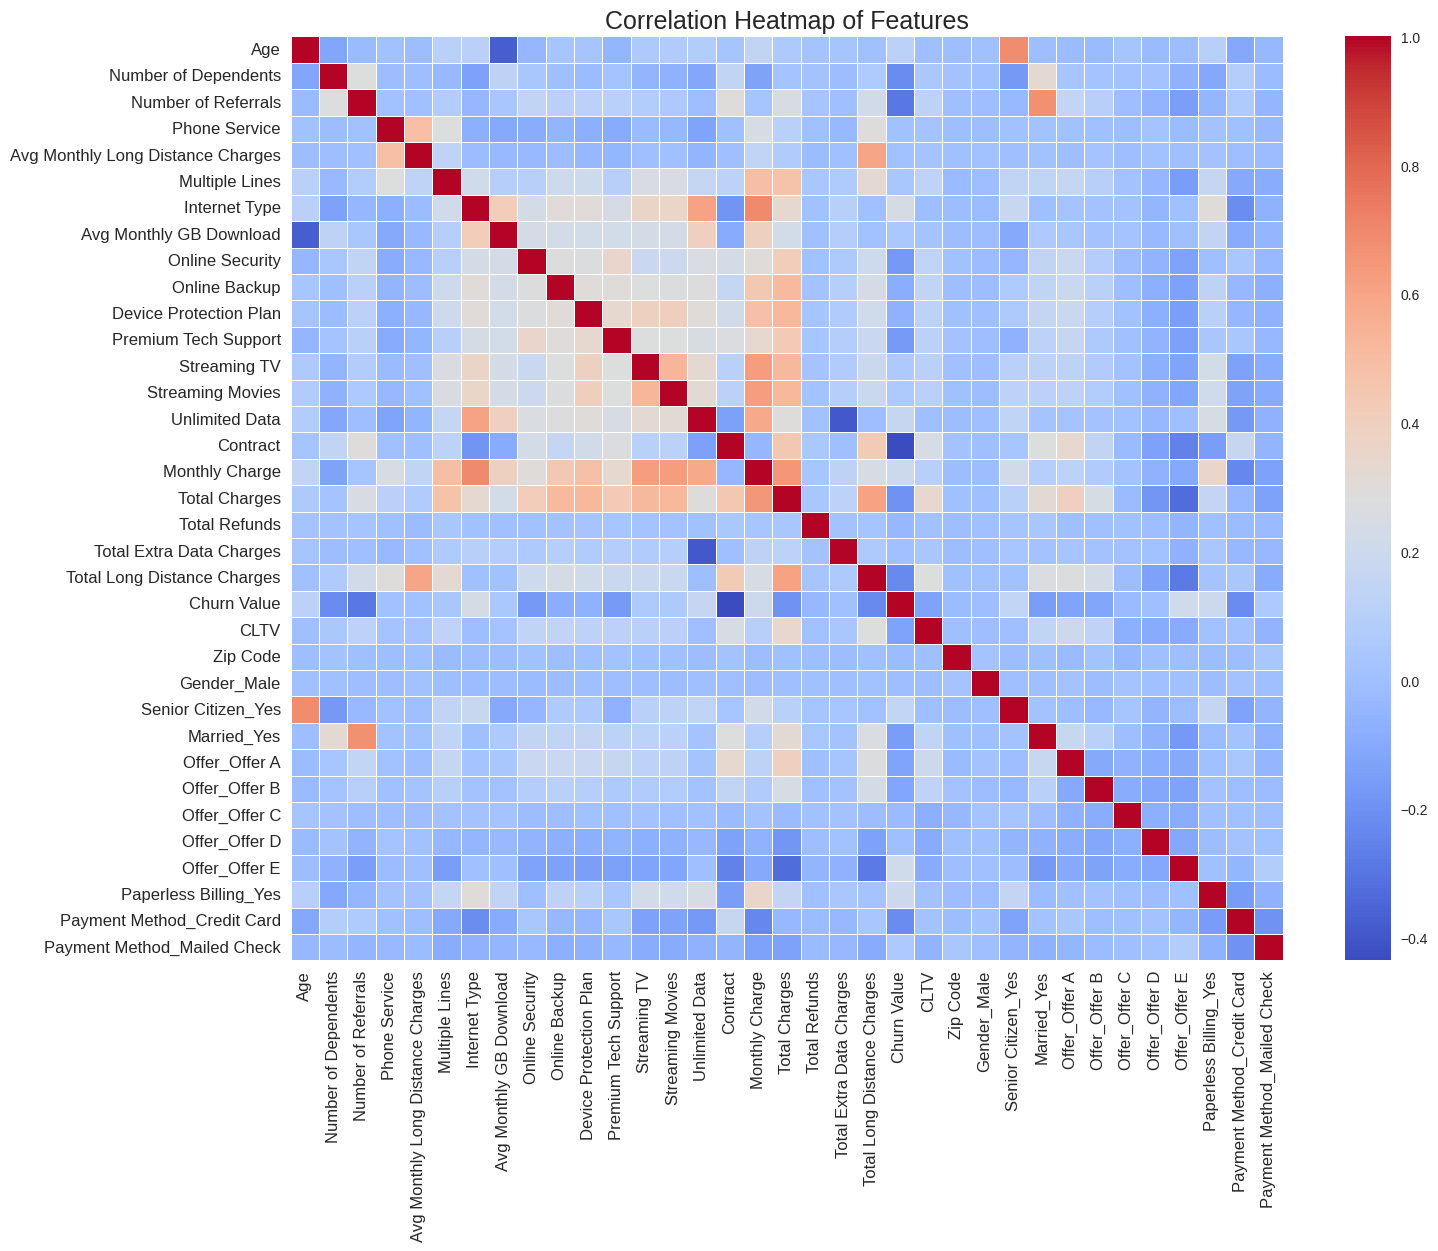

In [ ]:
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Create a heatmap with seaborn
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)

# Set titles and labels
plt.title('Correlation Heatmap of Features', fontsize=18)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.savefig('/content/drive/My Drive/correlation_matrix.png')


In [ ]:
strong_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs.index.get_level_values(0) != strong_corr_pairs.index.get_level_values(1)]
strong_corr_pairs = strong_corr_pairs[(strong_corr_pairs.abs() > 0.8) & (strong_corr_pairs.abs() < 1.0)]

# Print the pairs
print("Pairs with correlation stronger than |0.8|:")
print(strong_corr_pairs)

Pairs with correlation stronger than |0.8|:
Total Charges     Total Revenue       0.972212
Total Revenue     Total Charges       0.972212
Tenure in Months  Total Revenue       0.853146
Total Revenue     Tenure in Months    0.853146
Streaming Movies  Streaming Music     0.848528
Streaming Music   Streaming Movies    0.848528
Tenure in Months  Total Charges       0.826074
Total Charges     Tenure in Months    0.826074
dtype: float64


"Satisfaction Score" also has a high correlation with "Churn Value" (target variable) being -0.75. Maybe needs to be dropped? (Is this information available prior?)

In [ ]:
columns2drop = ['Total Revenue', 'Tenure in Months', 'Streaming Music']

df = df.drop(columns=columns2drop)

In [ ]:
df.shape

(7043, 35)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5]),
 [Text(0, 0.5, 'Age'),
  Text(0, 1.5, 'Number of Dependents'),
  Text(0, 2.5, 'Number of Referrals'),
  Text(0, 3.5, 'Phone Service'),
  Text(0, 4.5, 'Avg Monthly Long Distance Charges'),
  Text(0, 5.5, 'Multiple Lines'),
  Text(0, 6.5, 'Internet Type'),
  Text(0, 7.5, 'Avg Monthly GB Download'),
  Text(0, 8.5, 'Online Security'),
  Text(0, 9.5, 'Online Backup'),
  Text(0, 10.5, 'Device Protection Plan'),
  Text(0, 11.5, 'Premium Tech Support'),
  Text(0, 12.5, 'Streaming TV'),
  Text(0, 13.5, 'Streaming Movies'),
  Text(0, 14.5, 'Unlimited Data'),
  Text(0, 15.5, 'Contract'),
  Text(0, 16.5, 'Monthly Charge'),
  Text(0, 17.5, 'Total Charges'),
  Text(0, 18.5, 'Total Refunds'),
  Text(0, 19.5, 'Total Extra Data Charges'),
  Text(0, 20.5, 'Total L

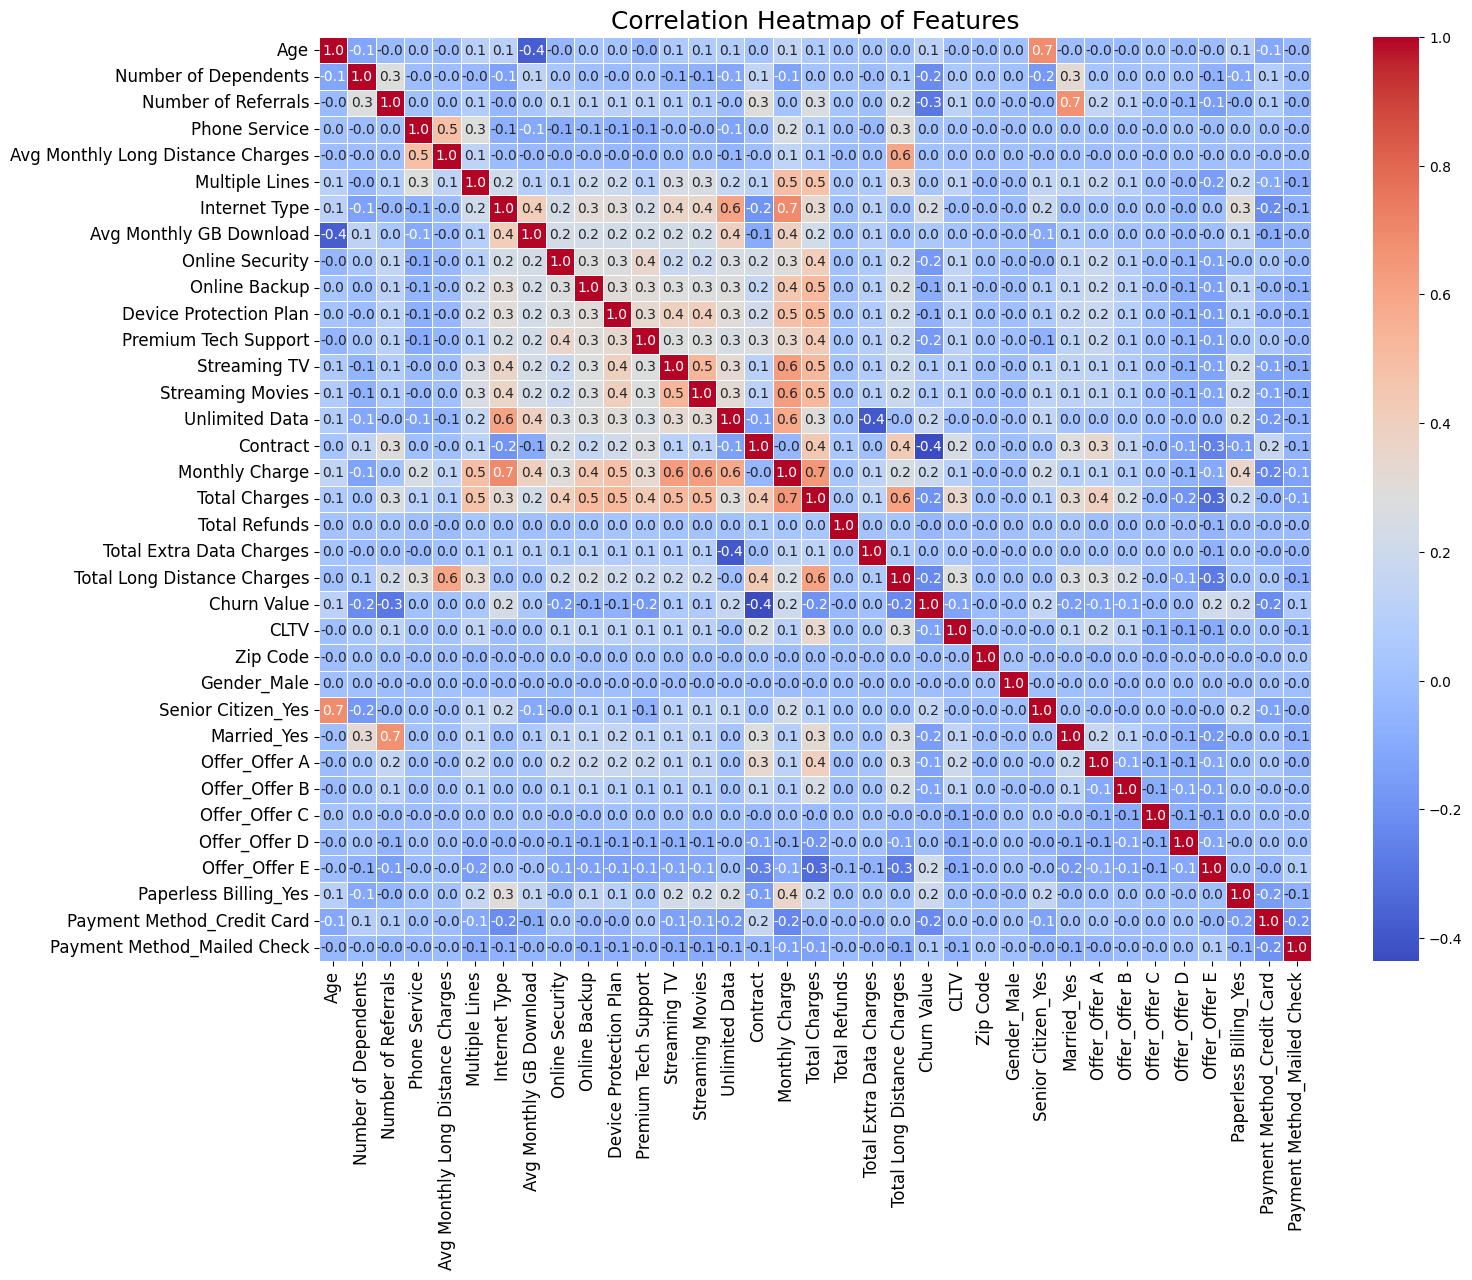

In [ ]:
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Create a heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm', linewidths=0.5)

# Set titles and labels
plt.title('Correlation Heatmap of Features', fontsize=18)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

#### Preprocessing is done here.

## Outlier detection:
For this we only investigate the numerical features.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                7043 non-null   int64  
 1   Number of Dependents               7043 non-null   int64  
 2   Number of Referrals                7043 non-null   int64  
 3   Phone Service                      7043 non-null   int64  
 4   Avg Monthly Long Distance Charges  7043 non-null   float64
 5   Multiple Lines                     7043 non-null   int64  
 6   Internet Type                      7043 non-null   int64  
 7   Avg Monthly GB Download            7043 non-null   int64  
 8   Online Security                    7043 non-null   int64  
 9   Online Backup                      7043 non-null   int64  
 10  Device Protection Plan             7043 non-null   int64  
 11  Premium Tech Support               7043 non-null   int64

In [ ]:
df.describe()

,Age,Number of Dependents,Number of Referrals,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,...,Senior Citizen_Yes,Married_Yes,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,Paperless Billing_Yes,Payment Method_Credit Card,Payment Method_Mailed Check
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,1.951867,0.903166,22.958954,0.421837,1.449950,20.515405,0.286668,0.344881,...,0.162147,0.483033,0.073832,0.116996,0.058924,0.085475,0.114298,0.592219,0.390317,0.054664
std,16.750352,0.962802,3.001199,0.295752,15.448113,0.493888,0.957423,20.418940,0.452237,0.475363,...,0.368612,0.499748,0.261516,0.321438,0.235499,0.279607,0.318195,0.491457,0.487856,0.227340
min,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,0.000000,0.000000,1.000000,9.210000,0.000000,1.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,46.000000,0.000000,0.000000,1.000000,22.890000,0.000000,2.000000,17.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,60.000000,0.000000,3.000000,1.000000,36.395000,1.000000,2.000000,27.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,80.000000,9.000000,11.000000,1.000000,49.990000,1.000000,3.000000,85.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


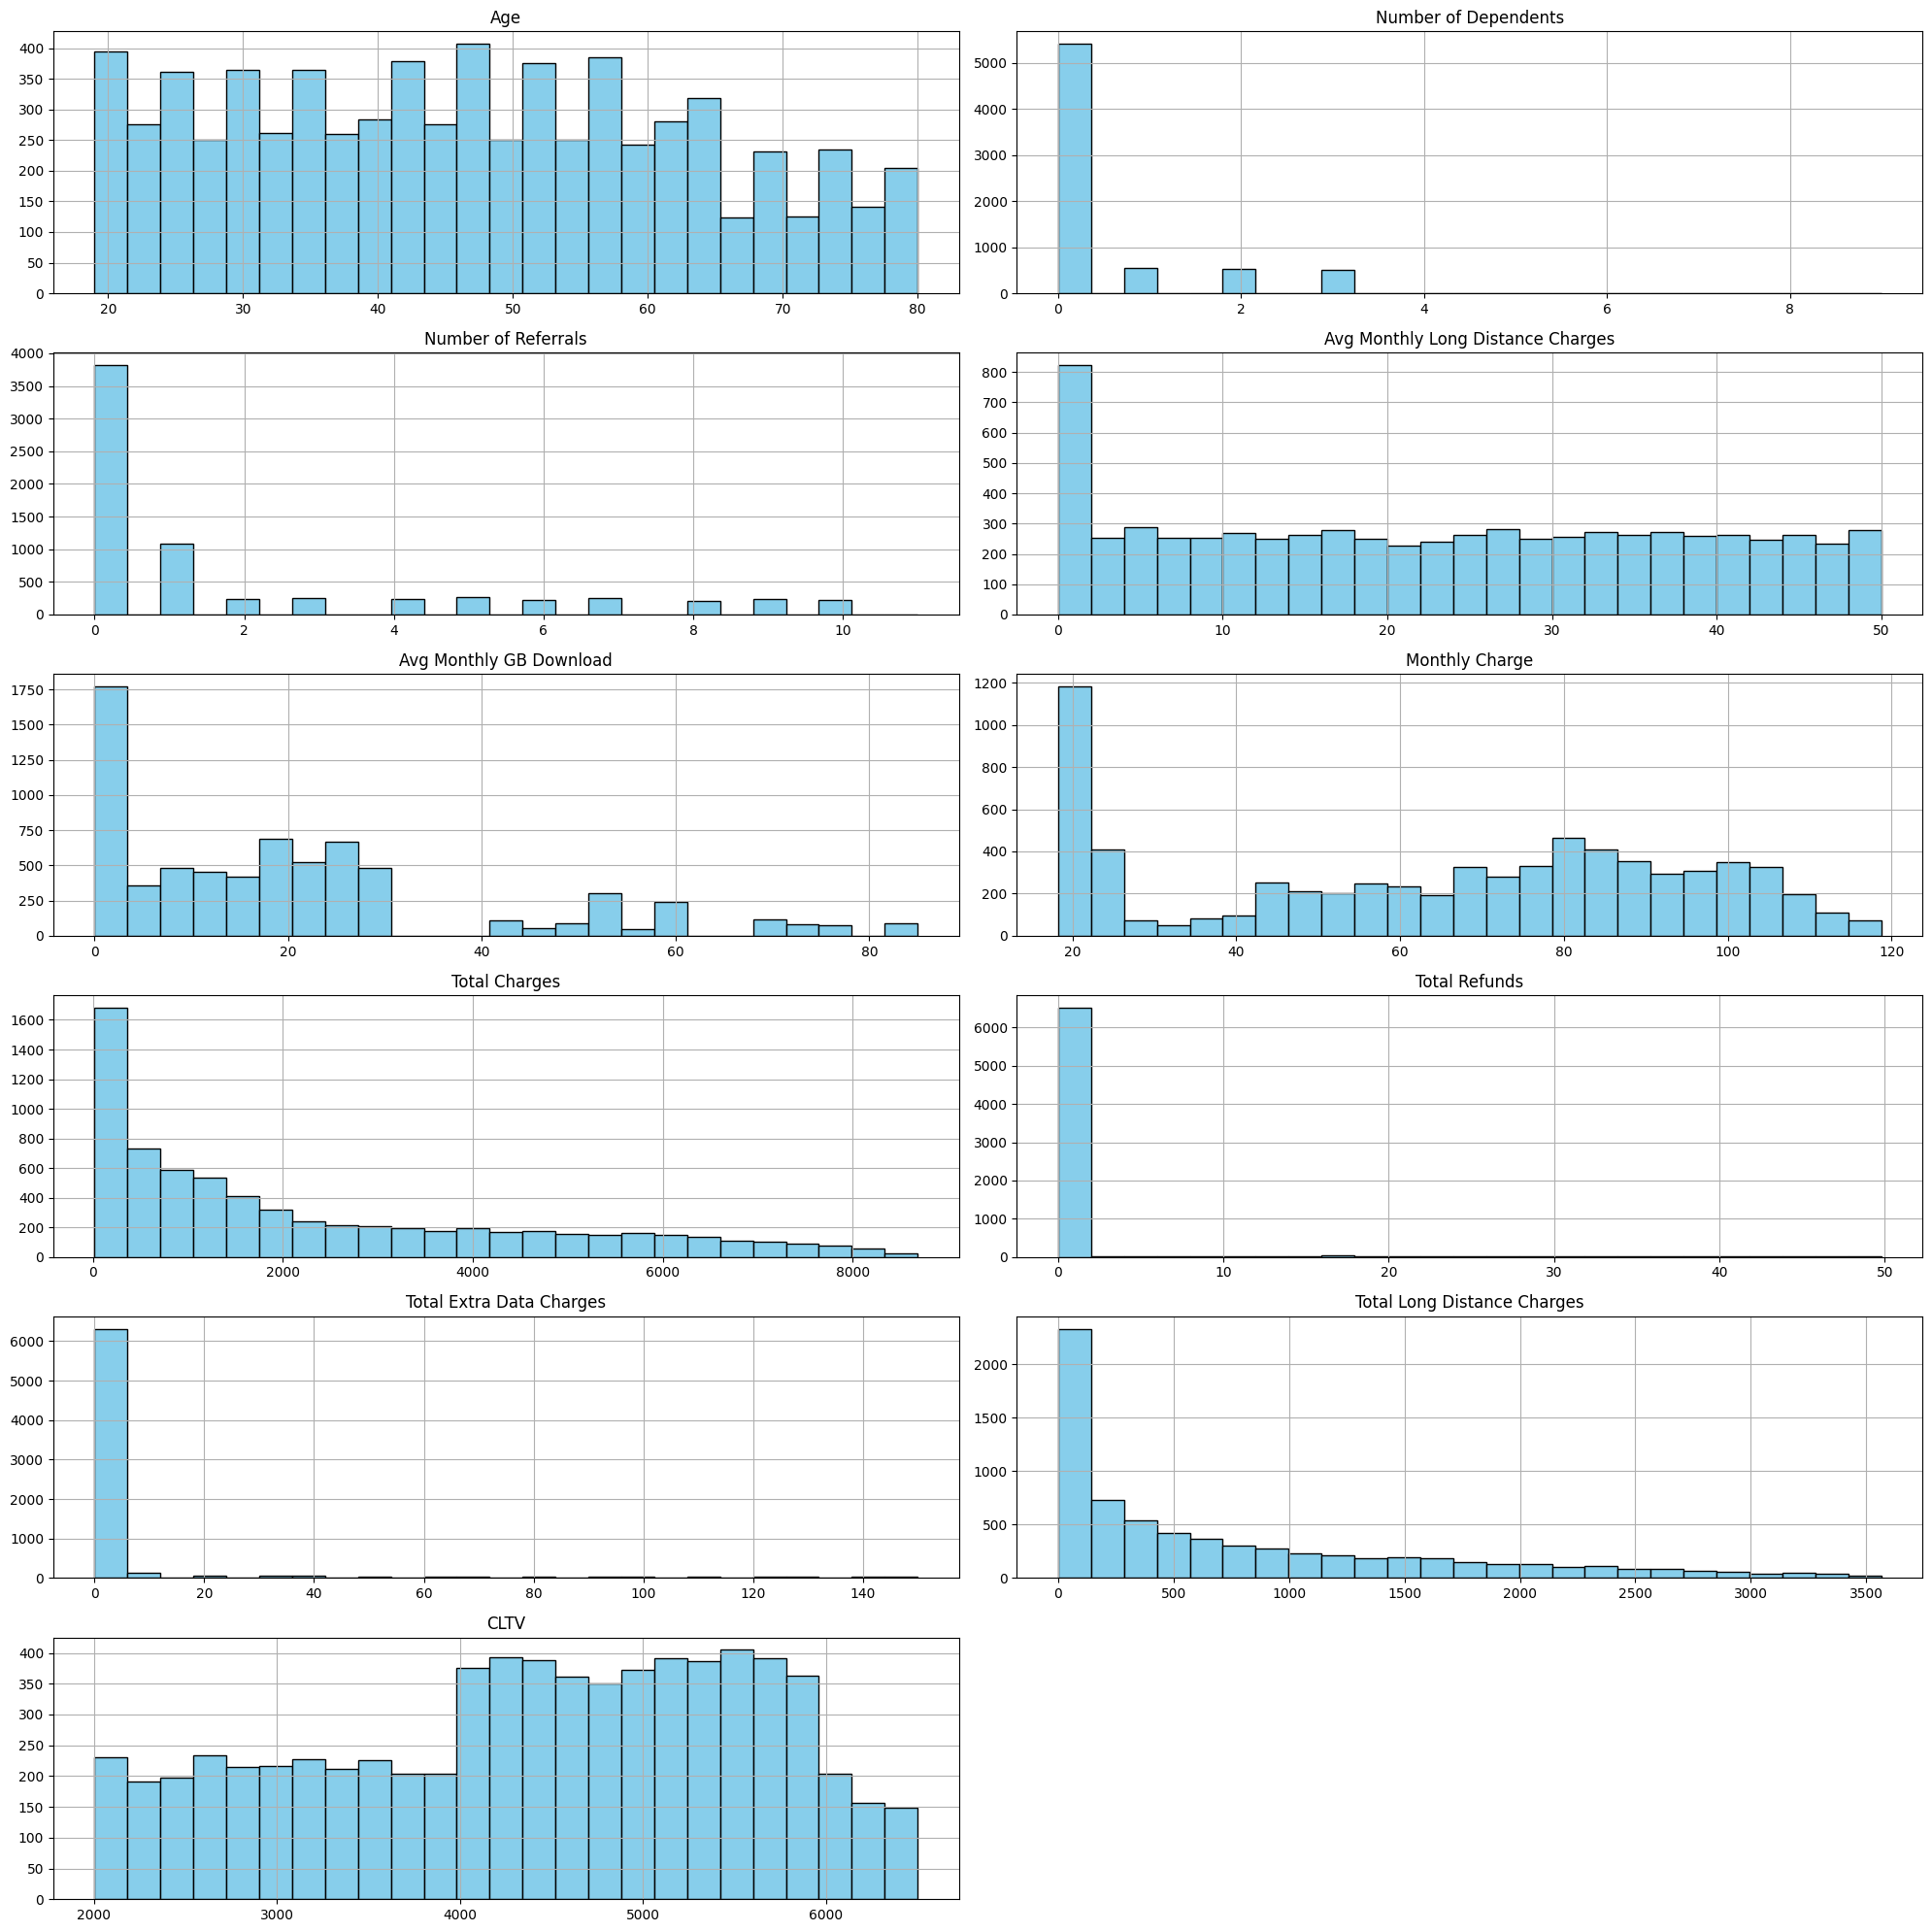

In [ ]:
exclude_columns = ['Tenure in Months', 'Total Revenue'] # removed these columns prior during preprocessing
numeric_columns_to_plot = [col for col in numeric_columns if col not in exclude_columns]

# Plotting histograms for the filtered numeric columns
df[numeric_columns_to_plot].hist(figsize=(20, 20), bins=25, layout=(6, 2), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()


Stuck atm with outlier detection/removal(what is best? 3 Sigma, boxplot etc...). Continue with building the model for now.

## Initiate model building:

1. Randomly make a 80:20 split.
2. Separate X (predictors) and y (target variable).

*TO KEEP IN MIND: OUR TARGET VARIABLE IS IMBALANCED*

In [ ]:
X = df.drop(['Churn Value'], axis = 1)
y = df['Churn Value']

In [ ]:
y.value_counts()

Churn Value
0    5174
1    1869
Name: count, dtype: int64

In [ ]:
# perform random 80:20 split of data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
data_train = pd.concat([X_train, y_train], axis=1)
data_train.head()

,Age,Number of Dependents,Number of Referrals,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,...,Married_Yes,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,Paperless Billing_Yes,Payment Method_Credit Card,Payment Method_Mailed Check,Churn Value
2142,37,0,0,1,25.51,0,2,16,0,0,...,0,0,0,0,0,0,1,0,0,1
1623,54,0,0,0,0.00,0,3,29,0,0,...,0,0,0,0,0,1,0,0,0,1
6074,24,1,4,1,41.02,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1362,23,0,0,1,21.58,0,2,71,0,0,...,0,0,0,0,0,1,0,0,1,1
6754,41,0,8,1,17.12,1,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0


In [ ]:
data_test = pd.concat([X_test, y_test], axis=1)
data_test.head()

,Age,Number of Dependents,Number of Referrals,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,...,Married_Yes,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,Paperless Billing_Yes,Payment Method_Credit Card,Payment Method_Mailed Check,Churn Value
185,73,0,1,1,26.95,0,2,26,0,0,...,1,0,0,0,0,0,0,0,0,1
2715,64,0,0,1,47.16,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3825,28,0,9,1,10.40,0,1,85,1,1,...,1,0,0,0,0,0,1,1,0,0
1807,35,3,1,1,29.01,0,0,0,0,0,...,1,0,0,0,1,0,1,1,0,1
132,67,0,1,1,31.70,1,3,6,0,0,...,1,0,0,0,0,0,1,0,0,1


In [ ]:
data_train.shape, data_test.shape

((5634, 35), (1409, 35))

## Setup Pycaret model to get a first impression of which models are promising candidates for further tuning.

Not sure if multicollinearity_threshold is required if we dropped anything greater than 0.8 beforehand. Also ouliers_threshold might not be required if we remove them before as well.

In [ ]:
from pycaret.classification import *

s = setup(data=data_train,
          target='Churn Value',  # "Expected" is the target variable
          session_id=42,
          remove_outliers=True,
          outliers_threshold=0.05,  # Adjust threshold as needed
          remove_multicollinearity=True,
          multicollinearity_threshold=0.9,  # Adjust threshold as needed
          normalize=True,  # Enable normalization
          transformation=True,  # Enable transformation to make data Gaussian
          feature_selection=True,  # Enable feature selection
          experiment_name='churn_prediction',
          n_jobs=-1)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1007, number of negative: 2738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 3745, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268892 -> initscore=-1.000252
[LightGBM] [Info] Start training from score -1.000252


,Description,Value
0,Session id,42
1,Target,Churn Value
2,Target type,Binary
3,Original data shape,"(5634, 35)"
4,Transformed data shape,"(5436, 7)"
5,Transformed train set shape,"(3745, 7)"
6,Transformed test set shape,"(1691, 7)"
7,Numeric features,34
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best_model = compare_models(fold=5, sort='Recall') # use 5 cross-validation sets

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7920,0.8061,0.4942,0.6311,0.5528,0.4202,0.4264,0.9920
lightgbm,Light Gradient Boosting Machine,0.7913,0.8090,0.4864,0.6294,0.5485,0.4157,0.4217,1.6860
catboost,CatBoost Classifier,0.7958,0.8214,0.4796,0.6477,0.5502,0.4221,0.4306,4.9520
xgboost,Extreme Gradient Boosting,0.7781,0.7959,0.4787,0.5950,0.5296,0.3867,0.3912,0.8680
gbc,Gradient Boosting Classifier,0.7986,0.8204,0.4767,0.6603,0.5528,0.4272,0.4372,1.4320
dt,Decision Tree Classifier,0.7147,0.6373,0.4757,0.4571,0.4656,0.2714,0.2718,1.1240
ada,Ada Boost Classifier,0.7946,0.8106,0.4737,0.6458,0.5463,0.4175,0.4261,0.8120
rf,Random Forest Classifier,0.7943,0.8037,0.4495,0.6544,0.5325,0.4065,0.4185,1.3120
lda,Linear Discriminant Analysis,0.7915,0.8119,0.4426,0.6483,0.5256,0.3980,0.4102,0.7660
et,Extra Trees Classifier,0.7925,0.8022,0.4291,0.6592,0.5187,0.3940,0.4094,0.9900


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
qda = create_model('qda', fold=5)
qda.get_params()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7909,0.7796,0.4563,0.6395,0.5326,0.4027,0.4122
1,0.7997,0.7916,0.5485,0.6348,0.5885,0.4571,0.4593
2,0.7871,0.8144,0.4757,0.6203,0.5385,0.4032,0.4092
3,0.8020,0.8437,0.4634,0.6738,0.5491,0.4278,0.4401
4,0.7805,0.8015,0.5268,0.5870,0.5553,0.4101,0.4111
Mean,0.7920,0.8061,0.4942,0.6311,0.5528,0.4202,0.4264
Std,0.0080,0.0220,0.0367,0.0282,0.0196,0.0206,0.0200


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

{'priors': None, 'reg_param': 0.0, 'store_covariance': False, 'tol': 0.0001}

In [ ]:
lightgbm = create_model('lightgbm', fold=5)
lightgbm.get_params()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7909,0.7839,0.4903,0.6273,0.5504,0.4168,0.4222
1,0.7769,0.8037,0.4515,0.5962,0.5138,0.3726,0.3787
2,0.7896,0.8034,0.4806,0.6266,0.5440,0.4103,0.4164
3,0.8058,0.8528,0.4927,0.6733,0.5690,0.4476,0.4567
4,0.7931,0.8011,0.5171,0.6235,0.5653,0.4312,0.4344
Mean,0.7913,0.8090,0.4864,0.6294,0.5485,0.4157,0.4217
Std,0.0092,0.0231,0.0212,0.0248,0.0197,0.0251,0.0255


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
catboost = create_model('catboost', fold=5)
catboost.get_params()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8010,0.7958,0.4757,0.6667,0.5552,0.4317,0.4418
1,0.7858,0.8024,0.4272,0.6331,0.5101,0.3796,0.3917
2,0.7972,0.8270,0.4951,0.6456,0.5604,0.4316,0.4380
3,0.8084,0.8695,0.4829,0.6875,0.5673,0.4491,0.4606
4,0.7868,0.8125,0.5171,0.6057,0.5579,0.4186,0.4209
Mean,0.7958,0.8214,0.4796,0.6477,0.5502,0.4221,0.4306
Std,0.0086,0.0262,0.0297,0.0280,0.0204,0.0233,0.0232


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

{'border_count': 254, 'verbose': False, 'task_type': 'CPU', 'random_state': 42}

## So it looks like QDA, decision tree classifier and xgboost are the best performing models so far.

Use GridSearchCV for QDA and RandomizedSearchCV for the other models to improve parameters even further.

In [ ]:
# QDA tuning
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

param_grid = {
    'priors': [None],  # You can experiment with different priors if needed
    'reg_param': [0.0, 0.1, 0.5], # Regularization parameter
    'store_covariance': [True, False], # Whether to store covariance matrices
    'tol': [0.0001, 0.001, 0.01]  # Tolerance for stopping criteria
}

grid_search = GridSearchCV(estimator=qda, param_grid=param_grid, cv=5, scoring='recall', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_qda = grid_search.best_estimator_

# Evaluate
accuracy = best_qda.score(X_test, y_test)
y_pred = best_qda.predict(X_test)
recall = recall_score(y_test, y_pred)
print(f"Best QDA model on test set gave: accuracy: {accuracy}, recall: {recall}")


best_params_qda = grid_search.best_params_
print(f"Best parameters found: {best_params_qda}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best QDA model on test set gave: accuracy: 0.8090844570617459, recall: 0.8175
Best parameters found: {'priors': None, 'reg_param': 0.0, 'store_covariance': True, 'tol': 0.0001}


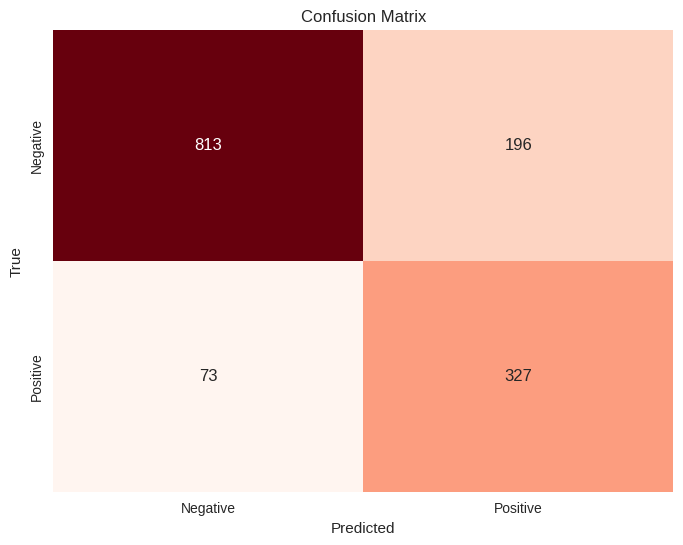

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/My Drive/confusion_matrix.png')
plt.show()

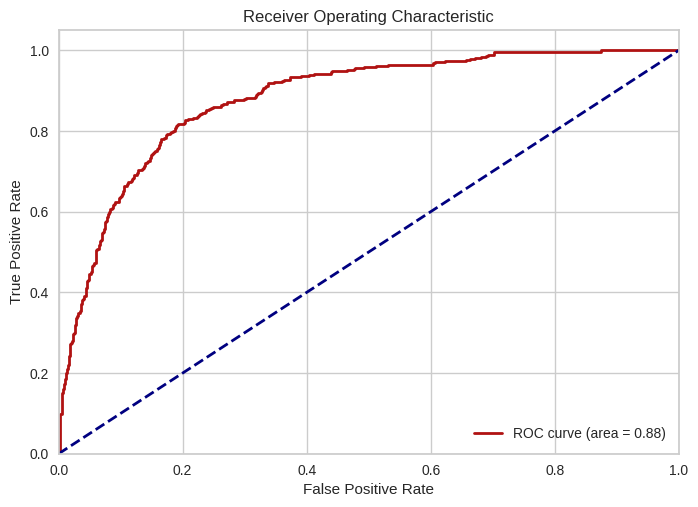

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get the probability predictions for the positive class
y_proba = best_qda.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='#b01212', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('/content/drive/My Drive/ROC.png')
plt.show()

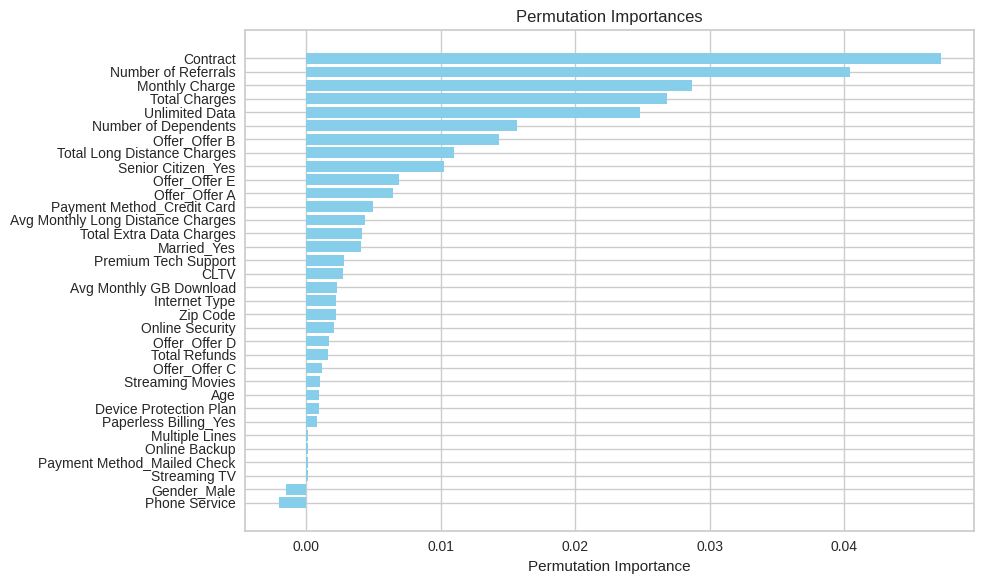

In [ ]:
from sklearn.inspection import permutation_importance

# Calculate permutation importances
result = permutation_importance(best_qda, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sort features by their mean importance
sorted_idx = result.importances_mean.argsort()

# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx], color='skyblue')
plt.xlabel("Permutation Importance")
plt.title("Permutation Importances")

# Adjust layout to avoid cutting off
plt.tight_layout()

# Save figure with proper layout adjustment
plt.savefig('/content/drive/My Drive/permutation_importances.png', bbox_inches='tight')


In [ ]:
# LIGHTGBM
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Define parameter distributions for RandomizedSearchCV
param_dist = {
    'boosting_type': ['gbdt'],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': sp_randint(6, 50),
    'max_depth': sp_randint(3, 15),
    'min_child_samples': sp_randint(100, 500),
    'subsample': sp_uniform(loc=0.6, scale=0.4),
    'colsample_bytree': sp_uniform(loc=0.6, scale=0.4),
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

# Initialize LightGBM classifier
lgb_model = lgb.LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# Initialize RandomizedSearchCV
randomized_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist,
                                       n_iter=50, scoring='recall', cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV to your data
randomized_search.fit(X_train, y_train)

# Get the best model and best parameters
best_lgb = randomized_search.best_estimator_
best_params_lgb = randomized_search.best_params_

# Evaluate the best model on the test set
accuracy = best_lgb.score(X_test, y_test)
y_pred = best_lgb.predict(X_test)
recall = recall_score(y_test, y_pred)
print(f"Best LightGBM model on test set gave: accuracy: {accuracy}, recall: {recall}")

# Print the best parameters found
print(f"Best parameters found: {best_params_lgb}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1469, number of negative: 4165
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260738 -> initscore=-1.042134
[LightGBM] [Info] Start training from score -1.042134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [ ]:
# Catboost tuning (use RandomizedSearchCV here as GridSearchCV would take too long for now)
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distributions for RandomizedSearchCV
param_dist_catboost = {
    'depth': sp_randint(4, 10),           # Depth of the trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate of gradient boosting
    'iterations': [50, 100, 200],         # Number of boosting iterations
    'l2_leaf_reg': sp_randint(1, 10),     # L2 regularization coefficient
    'border_count': [32, 64, 128, 254],   # Number of splits for numerical features
    'verbose': [False],                   # Whether to print messages during training
    'task_type': ['CPU'],                 # Training task type ('CPU' or 'GPU')
    'random_state': [42]                  # Random seed for reproducibility
}

# Initialize CatBoost classifier
cboost = CatBoostClassifier(border_count=254, verbose=False, task_type='CPU', random_state=42)

# Initialize RandomizedSearchCV (adjust n_iter depending on computational power)
random_search_catboost = RandomizedSearchCV(estimator=cboost, param_distributions=param_dist_catboost, n_iter=25,
                                           cv=5, scoring='f1', verbose=1, n_jobs=-1, random_state=42)

# Perform randomized search
random_search_catboost.fit(X_train, y_train)

# Get the best model and evaluate on test set
best_catboost = random_search_catboost.best_estimator_
accuracy = best_catboost.score(X_test, y_test)
y_pred = best_catboost.predict(X_test)
recall = recall_score(y_test, y_pred)
print(f"Best CatBoost model accuracy on test set: {accuracy}, recall: {recall}")

# Get the best parameters found
best_params_catboost = random_search_catboost.best_params_
print(f"Best parameters found: {best_params_catboost}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best CatBoost model accuracy on test set: 0.8516678495386799, recall: 0.675
Best parameters found: {'border_count': 32, 'depth': 5, 'iterations': 50, 'l2_leaf_reg': 2, 'learning_rate': 0.2, 'random_state': 42, 'task_type': 'CPU', 'verbose': False}


## Best performing model on accuracy is QDA with a accuracy of 89%. So we pick this model.